# Bayesian Online Change Point Detection (BOCPD)
## In Jax

Based on [this tutorial](http://gregorygundersen.com/blog/2019/08/13/bocd/)

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from itertools import product

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
p_stay = 0.97
p_move = 1 - p_stay

transition_matrix = jnp.array([
    [p_stay, p_move, 0.0, 0.0],
    [0.0, p_stay, p_move, 0.0],
    [0.0, 0.0, p_stay, p_move],
    [p_move, 0.0, 0.0, p_stay],
])

n_states, _ = transition_matrix.shape

In [4]:
means = jnp.array([0, -5, 3, -2])
tau = 1

In [5]:
T = 200

def step_hmm(key, s_prev):
    p_transition = transition_matrix[s_prev, :]
    s_next = jax.random.choice(key, n_states, p=p_transition)
    return s_next

def step_process(s_prev, key):
    key_obs, key_step = jax.random.split(key)
    
    s_next = step_hmm(key_step, s_prev)
    mean = means[s_next]
    obs_next = jax.random.normal(key_obs) / tau + mean
    
    output = {
        "state": s_next,
        "obs": obs_next,
        "s_prev": s_next
    }
    return s_next, output

In [43]:
jnp.exp(1)

DeviceArray(2.7182817, dtype=float32)

In [44]:
key = jax.random.PRNGKey(27182)
key_init, key_steps = jax.random.split(key)
keys = jax.random.split(key_steps, T)

s_init = jax.random.choice(key_init, n_states)
_, outputs = jax.lax.scan(step_process, s_init, keys, unroll=3)
X =outputs["obs"]

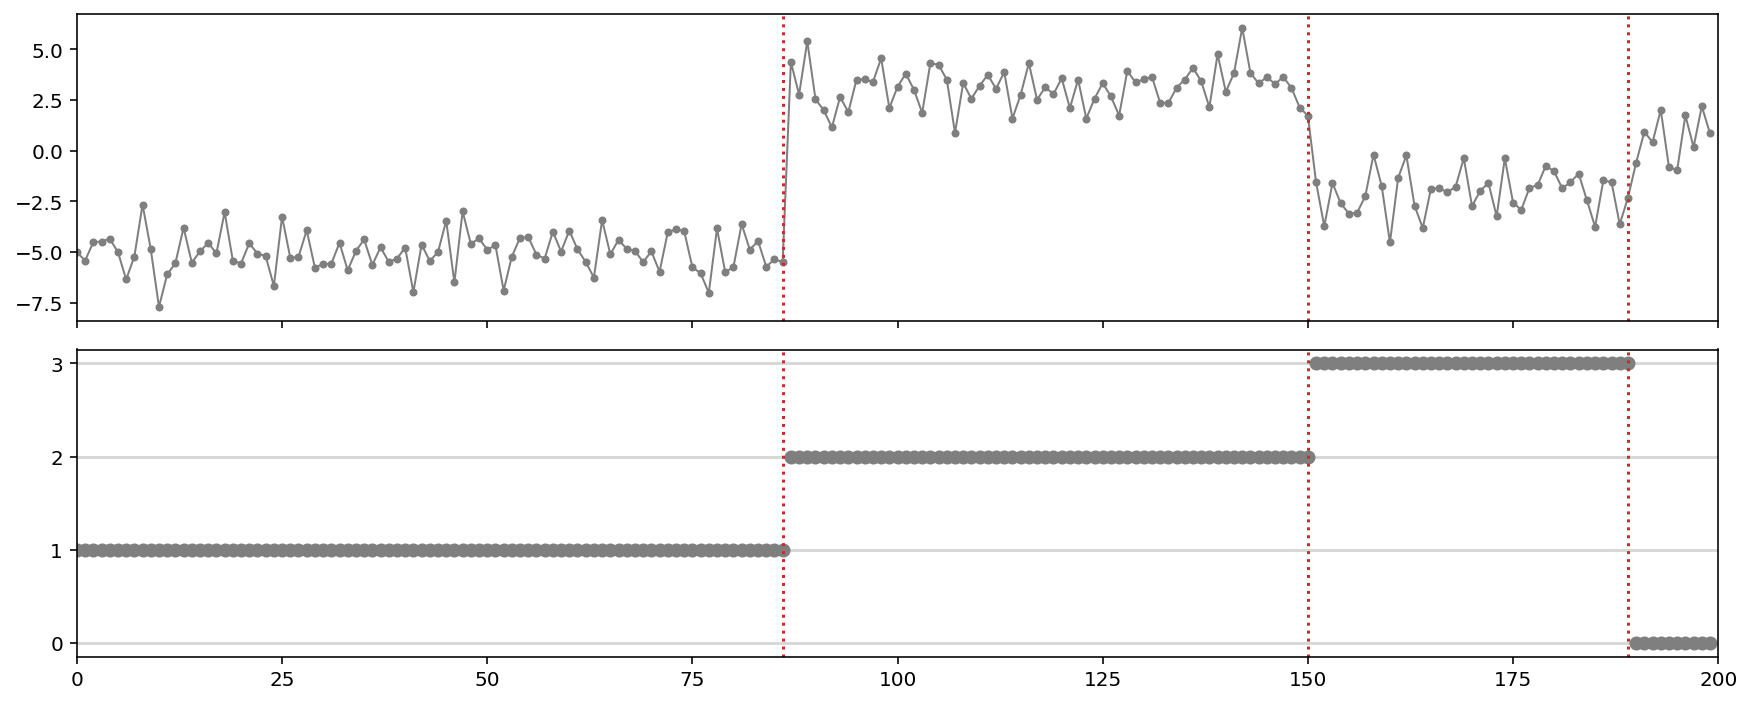

In [45]:
timesteps = jnp.arange(T)
changepoints, *_ = jnp.where(jnp.diff(outputs["state"]) != 0)


fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex="all")

ax[0].plot(timesteps, X, marker="o", markersize=3, linewidth=1, c="tab:gray")

ax[1].scatter(timesteps, outputs["state"], c="tab:gray")
ax[1].set_yticks(jnp.arange(n_states))
for y in range(n_states):
    ax[1].axhline(y=y, c="tab:gray", alpha=0.3)
    
for changepoint, axi in product(changepoints, ax):
    axi.axvline(x=changepoint, c="tab:red", linestyle="dotted")
    
plt.tight_layout()
plt.xlim(0, T);

## Implementation

In [46]:
from jax.scipy import stats

In [259]:
def run_lenght_pred(x, mean, prec):
    return stats.norm.pdf(x, mean, jnp.sqrt(1 / prec + 1))

compute_run_length_vmap = jax.vmap(run_lenght_pred, in_axes=(None, 0, 0))

def bocpd_step(state, xt):
    time = state["time"]
    mu_old = state["mean"][time]
    prec_old = state["precision"][time]
    pred_old = state["pred"]
    
    predictive_run_length = compute_run_length_vmap(xt, state["mean"], state["precision"])
    
    pred_new_0 = (state["pred"] * predictive_run_length * H).sum()
    pred_new = state["pred"] * predictive_run_length * (1 - H)
    
    state["pred"] = jnp.r_[pred_new_0, pred_new[:-1]]
    state["pred"] = state["pred"] / state["pred"].sum()
    
    mu_new = (time * mu_old + xt) / (time + 1)
    prec_new = 1 + prec_old
    
    state["time"] = state["time"] + 1
    state["mean"] = state["mean"].at[time + 1].set(mu_new)
    state["precision"] = state["precision"].at[time + 1].set(prec_new)
    
    return state, state["pred"]

In [462]:
def run_lenght_pred(x, mean, prec):
    return stats.norm.logpdf(x, mean, jnp.sqrt(1 / prec + 1))

compute_run_length_vmap = jax.vmap(run_lenght_pred, in_axes=(None, 0, 0))

def bocpd_step(state, xt):
    time = state["time"]
    mu_old = state["mean"][time]
    prec_old = state["precision"][time]
    pred_old = state["log_pred"]
    
    log_predictive_run_length = compute_run_length_vmap(xt, state["mean"], state["precision"])
    
    pred_new_0 = jax.nn.logsumexp(state["log_pred"] + log_predictive_run_length + jnp.log(H))
    
    pred_new = state["log_pred"] + log_predictive_run_length  + jnp.log((1 - H))
    
    state["log_pred"] = jnp.r_[pred_new_0, pred_new[:-1]]
    state["log_pred"] = state["log_pred"] - jax.nn.logsumexp(state["log_pred"])
    
    mu_new = (time * mu_old + xt) / (time + 1)
    prec_new = 1 + prec_old
    
    state["time"] = state["time"] + 1
#     state["mean"] = state["mean"].at[time + 1].set(mu_new)
    state["mean"] = (state["mean"] * jnp.arange(1, T + 1) + xt) / (jnp.arange(2, T + 2))
    state["mean"] = state["mean"] * (time >= jnp.arange(T))
    state["precision"] = state["precision"].at[time + 1].set(prec_new)
    
    return state, state

In [463]:
mu_hat, lambda_hat = 0, 1.0

H = 1 / 60
H = len(changepoints) / T

init_state = {
    "time": 0,
    "mean": jnp.zeros(T).at[0].set(mu_hat),
    "precision": jnp.zeros(T).at[0].set(lambda_hat),
    "log_pred": jnp.zeros(T).at[0].set(0.0),
    "suff": 0
}

final_state, hist_state = jax.lax.scan(bocpd_step, init_state, X)
pred = hist_state["log_pred"]

(0.00000, 26.00000)

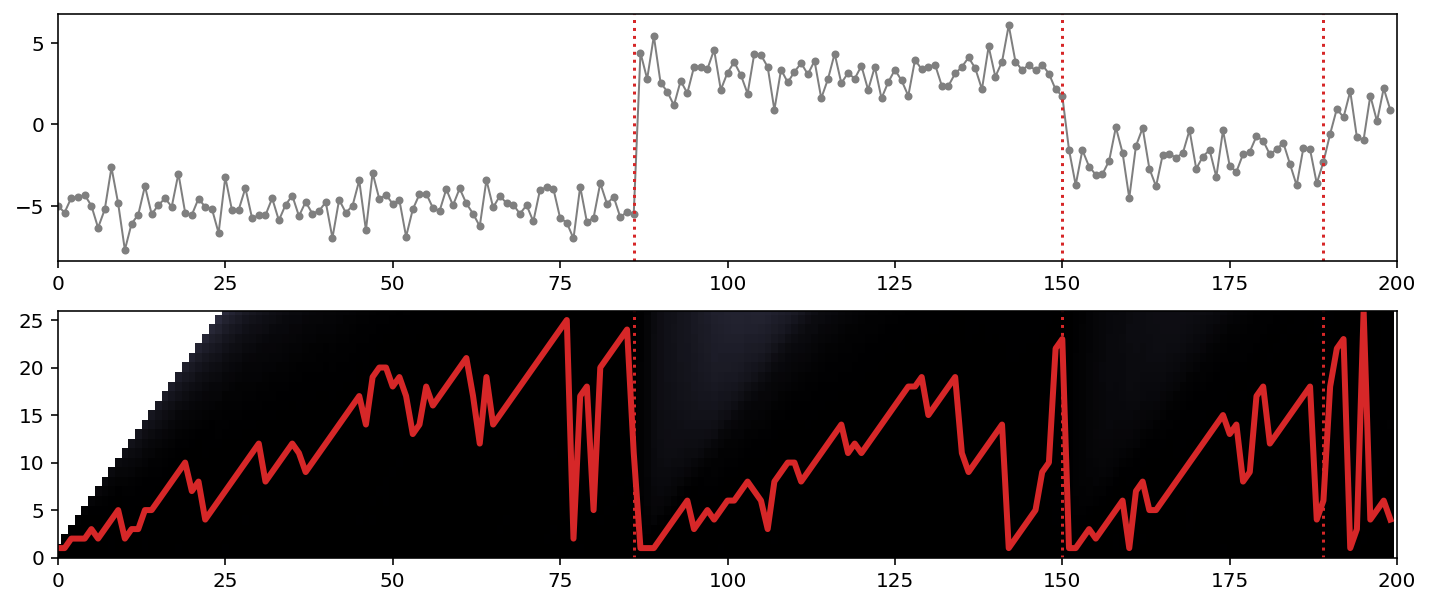

In [464]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5))

r_max = pred.argmax(axis=1).max()
ax[1].plot(pred.argmax(axis=1), c="tab:red", linewidth=3)
ax[1].imshow(jnp.rot90(pred, k=3)[:, ::-1], origin="lower", aspect="auto", cmap="bone_r")

ax[0].plot(timesteps, X, marker="o", markersize=3, linewidth=1, c="tab:gray")

ax[0].set_xlim(0, T)
ax[1].set_xlim(0, T)
for changepoint, axi in product(changepoints, ax):
    axi.axvline(x=changepoint, c="tab:red", linestyle="dotted")


ax[1].set_ylim(0, r_max)